# Demo of the Materials Resource Registry combined with OPTIMADE

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/usnistgov/nmrr-optimade-demo/main?labpath=mrr_optimade_oqmd_query_demo.ipynb)

Chandler Becker, *NIST*  
Matthew Evans, *UCLouvain*

This demo notebook walks through how to query for OPTIMADE APIs that have been registered within any of the federated Materials Resource Registry (MRR) endpoints. 
The results from MRR are then used to construct OPTIMADE API queries and make some plots of relevant data.

The notebook can be run at [Binder](https://mybinder.org/v2/gh/usnistgov/nmrr-optimade-demo/main?labpath=mrr_optimade_oqmd_query_demo.ipynb), or locally after installing the dependencies from the `requirements.txt` file into a Python 3.8+ virtual environment.
More information can be found in the code repository on GitHub at [unistgov/nmrr-optimade-demo](https://github.com/usnistgov/nmrr-optimade-demo).

In [1]:
# Import 
import json
import cdcs
import pandas as pd
import lxml.etree as et
import requests

# define which MRR instances to query
mrr_instance_urls = ["https://materials.registry.nist.gov/", "https://mrr.materialsdatafacility.org/"]
mrr_instances = [cdcs.CDCS(url, username='') for url in mrr_instance_urls]

# define search parameters
search_string = 'optimade'

# query MRR instances for records that mention OPTIMADE
records = pd.concat(
    [
        mrr.query(mongoquery={"$text": {"$search": search_string}})
        for mrr in mrr_instances
    ]
)
records

,id,template,workspace,user_id,title,xml_content,creation_date,last_modification_date,last_change_date,template_title
0,61e6b7876e07c8cff02ec404,61e6b6d3051f5e060530b206,61e6b6d3051f5e060530b205,53,optimade-python-tools,"<Resource xmlns:xsi=""http://www.w3.org/2001/XM...",2021-12-02T21:27:43.420000Z,2021-12-02T21:28:44.562000Z,2021-12-02T21:28:44.400000Z,res-md.xsd
1,624b054858e35a2c06253db0,61e6b6d3051f5e060530b206,61e6b6d3051f5e060530b205,53,Open Database of Xtals (odbx),"<Resource xmlns:xsi=""http://www.w3.org/2001/XM...",2022-04-04T14:48:37.898000Z,2022-04-04T14:48:46.530000Z,2022-04-04T14:48:37.898000Z,res-md.xsd
2,61e6b72ee5c88a96b78cfb1c,61e6b6d3051f5e060530b206,61e6b6d3051f5e060530b205,4,JARVIS-DFT.xml,"<Resource xmlns:xsi=""http://www.w3.org/2001/XM...",2021-08-12T13:43:58.581000Z,2022-04-11T12:08:11.318000Z,2022-04-11T12:08:11.145000Z,res-md.xsd
0,61e6c52048175bd317b973a7,61e6c4a1266710654b351df2,61e6c4b06be34c420cd142f0,6,oqmd.xml,"<Resource xmlns:xsi=""http://www.w3.org/2001/XM...",2021-12-22T20:26:31.744000Z,2022-02-01T15:04:27.462000Z,2022-02-01T15:04:27.413000Z,res-md.xsd


In [2]:
# parse returned MRR records using the lxml etree library
# for each matching record, perform query via the API (if applicable)
optimade_filter = '/v1/structures?filter=chemical_formula_reduced="O2Si"'


for idx, record in records.iterrows():
    xml_root = et.fromstring(record.xml_content)

    # map 'default_ns' to the MRR res-md schema 
    # (e.g., 'http://schema.nist.gov/xml/res-md/1.0wd-02-2017')
    # to support queries.
    # lxml info and tutorials: https://lxml.de/tutorial.html
    nsmap = {('default_ns',ns[1]) for ns in xml_root.xpath('//namespace::*') if (ns[0]==None)}
    
    # if OPTIMADE baseURL is not empty, then perform query of that resource
    for link in xml_root.xpath(".//default_ns:baseURL", namespaces=nsmap):
        database_info = requests.get(link.text + "/v1/info", verify=False).json()
        structure_info = requests.get(link.text + "/v1/info/structures", verify=False).json()

        optimade_query = link.text + optimade_filter
        print(record.title)
        print('Executing OPTIMADE query: ', optimade_query)
        r = requests.get(optimade_query, verify=False).json()
        data = r["data"]
        try:
            r.get('meta')
            print(f"Number of results: {r['meta']['data_returned']}")
            # Request pages of OPTIMADE data
            while r["meta"]["more_data_available"] and r["links"].get("next"):
                r = requests.get(r["links"]["next"], verify=False).json()
                data.extend(r["data"])
                print(f'Fetched {len(data)}/{r["meta"]["data_returned"]} records')
        except KeyError:
            print('Could not find "meta".  Resource not queried.')


Open Database of Xtals (odbx)
Executing OPTIMADE query:  https://optimade.odbx.science/v1/structures?filter=chemical_formula_reduced="O2Si"
Number of results: 0
JARVIS-DFT.xml
Executing OPTIMADE query:  https://jarvis.nist.gov/optimade/jarvisdft/v1/structures?filter=chemical_formula_reduced="O2Si"
Could not find "meta".  Resource not queried.
oqmd.xml
Executing OPTIMADE query:  http://oqmd.org/optimade/v1/structures?filter=chemical_formula_reduced="O2Si"
Number of results: 176
Fetched 100/176 records
Fetched 150/176 records
Fetched 176/176 records


In [3]:
oqmd_fields_dict = {field: structure_info["data"]["properties"][field] for field in structure_info["data"]["properties"]}

In [4]:
df = pd.DataFrame(columns=[k for k in oqmd_fields_dict.keys() if k.startswith("_oqmd") or k == "nsites"])

for i in range(0, len(data)):
    df = df.append({k:v for k,v in data[i]["attributes"].items() if k in df.columns}, ignore_index=True)
    
df

,nsites,_oqmd_direct_site_positions,_oqmd_entry_id,_oqmd_calculation_id,_oqmd_icsd_id,_oqmd_band_gap,_oqmd_delta_e,_oqmd_volume,_oqmd_stability,_oqmd_prototype,_oqmd_spacegroup
0,3,NaN,8352,8668,44271,2.245,-1.8130,23.3550,1.261,CaF2,Fm-3m
1,6,NaN,6607,18953,35536,5.596,-3.0728,101.0910,0.001,Cristobalite high,Fd-3m
2,6,NaN,13603,20480,75648,6.374,-3.0694,82.5578,0.004,SiO2(I4-2d),I-42d
3,6,NaN,20578,20771,162660,6.268,-3.0722,83.4472,0.001,None,I-42d
4,9,NaN,16288,54541,93975,5.869,-3.0680,121.1590,0.006,"Quartz,high",P6422
...,...,...,...,...,...,...,...,...,...,...,...
171,72,NaN,21631,3751030,170490,5.908,-3.0165,1195.3400,0.057,None,Pm-3n
172,72,NaN,111543,3761286,170518,5.947,-2.9951,969.9510,0.079,None,R-3
173,72,NaN,98601,3766291,155684,5.588,-3.0663,1264.1000,0.007,None,P1
174,72,NaN,32269,3770962,176,5.988,-3.0543,943.9910,0.019,SiO2(mS144),Cc


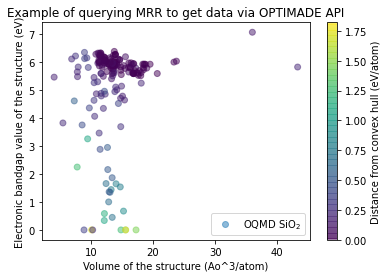

In [5]:
# plot returned data.
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
x_field = "_oqmd_volume"
y_field = "_oqmd_band_gap"
c_field = "_oqmd_stability"
scatter = ax.scatter(
       df[x_field] / df["nsites"], 
       df[y_field],
       c=df[c_field], alpha=0.5, label=f'{database_info["meta"]["provider"]["name"]} SiO$_2$')
plt.colorbar(scatter, label="Distance from convex hull (eV/atom)")

x_desc, x_unit = oqmd_fields_dict[x_field]["description"], oqmd_fields_dict[x_field]["unit"] + "/atom"
y_desc, y_unit = oqmd_fields_dict[y_field]["description"], oqmd_fields_dict[y_field]["unit"]

ax.set(
       xlabel=f"{x_desc} ({x_unit})", 
       ylabel=f"{y_desc} ({y_unit})", 
       title='Example of querying MRR to get data via OPTIMADE API')
plt.legend(loc='lower right')
plt.show()

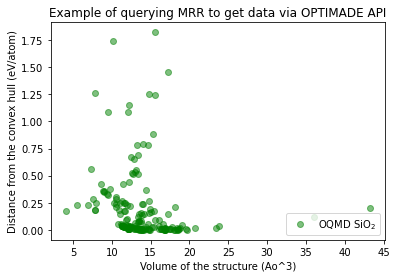

In [6]:
# plot returned data.
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
x_field = "_oqmd_volume"
y_field = "_oqmd_stability"
ax.scatter(
       df[x_field] / df["nsites"], 
       df[y_field],
       c="g", alpha=0.5, label=f'{database_info["meta"]["provider"]["name"]} SiO$_2$')

x_desc, x_unit = oqmd_fields_dict[x_field]["description"], oqmd_fields_dict[x_field]["unit"]
y_desc, y_unit = "Distance from the convex hull", oqmd_fields_dict[y_field]["unit"]

ax.set(
       xlabel=f"{x_desc} ({x_unit})", 
       ylabel=f"{y_desc} ({y_unit})", 
       title='Example of querying MRR to get data via OPTIMADE API')
plt.legend(loc='lower right')
plt.show()

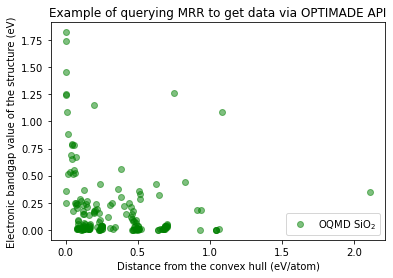

In [7]:
# plot returned data.
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
x_field = "_oqmd_band_gap"
y_field = "_oqmd_stability"
ax.scatter(
       df[x_field] / df["nsites"], 
       df[y_field],
       c="g", alpha=0.5, label=f'{database_info["meta"]["provider"]["name"]} SiO$_2$')

x_desc, x_unit = "Distance from the convex hull", oqmd_fields_dict[y_field]["unit"]
y_desc, y_unit = oqmd_fields_dict[x_field]["description"], oqmd_fields_dict[x_field]["unit"]

ax.set(
       xlabel=f"{x_desc} ({x_unit})", 
       ylabel=f"{y_desc} ({y_unit})", 
       title='Example of querying MRR to get data via OPTIMADE API')
plt.legend(loc='lower right')
plt.show()

In [8]:
# Use optimade-python-tools module to convert to Python data models, then visualise with ASE
from optimade.adapters import Structure
import warnings
import random
structures = []
warnings.filterwarnings(action="ignore")

for structure in random.sample(data, 9):
    structure["attributes"]["elements_ratios"] = None
    structure["attributes"]["species"] = None
    try:
        structures.append(Structure(structure))
    except Exception as exc:
        print(f'Error with structure ID: {structure["id"]}: {exc}')


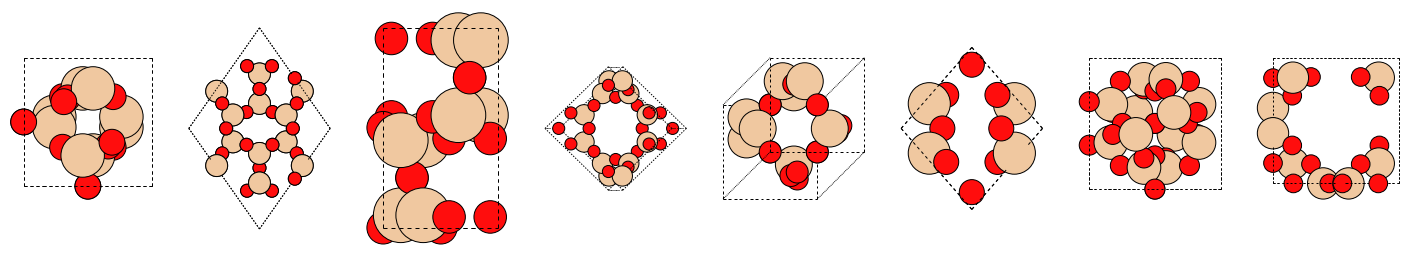

In [9]:
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 8, figsize=(25, 8))
for ind, ax in enumerate(axes):
    plot_atoms(structures[ind].as_ase, ax)
    ax.set_axis_off()